# Experimenting with Matrix Factorization and the MovieLens Dataset

This notebook will allow you to experiment with the parameters of matrix factorization with the MovieLens dataset. I'm using the 100k dataset, and storing it in a sparse matrix. 

We're going to differentiate training and testing errors. Our main goal here has to be avoiding overfitting, so we want a testing error as close to the training error as we can get it. With a large number of latent features, it is very possible to get a very low training error. However, that will negatively impact our testing error, and since our model's performance on items a user has already rated is of absolutely no interest to us, let's just go ahead and prioritize our testing error like never before. 

## Matrix Factorization

In [139]:
import numpy as np
from scipy.sparse import lil_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
users,movies = list(),list()

for line in data_file.readlines():
    line = line.split()
    user = int(line[0])
    movie = int(line[1])
    users.append(user)
    movies.append(movie)

users = np.unique(users)
movies = np.unique(movies)
print('Number of users:',len(users))
print('Number of movies:',len(movies))

# fair warning: we're not gonna use those a lot
# it's good to have them though
user_to_id = dict(zip(users,range(len(users))))
movie_to_id = dict(zip(movies,range(len(movies))))
id_to_user = dict(zip(range(len(users)),users))
id_to_movie = dict(zip(range(len(movies)),movies))

data = lil_matrix((len(users),len(movies)))

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
for line in data_file.readlines():
    line = line.split()
    user = user_to_id[int(line[0])]
    movie = movie_to_id[int(line[1])]
    rating = int(line[2])
    data[user,movie] = rating
    
print('Number of ratings:',data.nnz)

Number of users: 943
Number of movies: 1682
Number of ratings: 100000


### Parameters to optimize:

- K = number of latent features
- lr = learning rate
- error_threshold = absolute point you're willing to have as an error on your values
    (A threshold of 0.5 means you think getting a rating wrong by 0.5 points is acceptable.)
- split = proportion of the data you'll use for training
- max_time = a variation of max_iters (number of seconds the loop is allowed to run for)

I use the mean absolute error as the error can be positive or negative, and the absolute value is easier to visualize than the mean square error. 


Mean absolute error at iteration 0: (time = 0.00023221969604492188 )
	Train: 1.6647109156610298 	Test: 1.6475457011955674

Mean absolute error at iteration 5: (time = 23.970256805419922 )
	Train: 0.635794894787407 	Test: 0.8052217899582247

Mean absolute error at iteration 10: (time = 46.31491017341614 )
	Train: 0.5540249224291052 	Test: 0.8405367299008114

Mean absolute error at iteration 15: (time = 68.30732417106628 )
	Train: 0.5155527794994433 	Test: 0.8680937449170886

Mean absolute error at iteration 20: (time = 92.89574718475342 )
	Train: 0.49479764448363833 	Test: 0.8887124591523933

Mean absolute error at iteration 25: (time = 116.90063095092773 )
	Train: 0.48200133016035623 	Test: 0.9058279562951993


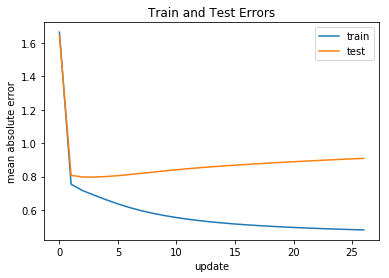

In [132]:
n = len(users)
m = len(movies)
K = 20
# If you raise the learning rate too much you'll get overflow errors.
#   -> I'd leave it at .01.
lr = .01
show_every = 5
error_threshold = .1
split = .8
max_time = 120

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)

# entries = cells that contain a value in our data matrix
entries = list(zip(*data.nonzero()))
n_train = int(len(entries)*split)
all_indices = np.arange(len(entries))
train_indices = np.random.choice(all_indices,n_train,replace=False)
train_entries = [entries[i] for i in train_indices]
test_indices = np.setdiff1d(all_indices,train_indices)
test_entries = [entries[i] for i in test_indices]

# r = matrix with actual values (here = data)
# local_entries: so we can decide which entries to give 
#     -> differentiate learning and testing errors
def mean_absolute_error(r,p,q,local_entries):
    error = 0
    for (i,j) in local_entries:
        current_error = r[i,j]
        for k in range(K): current_error -= p[i,k]*q[j,k]
        error += abs(current_error)
    return error/len(local_entries)

error_train = mean_absolute_error(data,p,q,train_entries)
error_test = mean_absolute_error(data,p,q,test_entries)
# saving errors so we can plot them (F U N)
train_errors = [error_train]
test_errors = [error_test]
start = time.time()
iter=0
    
    
#################################################
################# TRAINING LOOP #################
#################################################

while error_test > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0:
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        local_error = data[i,j] - sum([p[i,k]*q[j,k] for k in range(K)])
        for k in range(K):
            # updating equations = derivatives of the error per parameter
            p[i,k] += 2*lr*local_error*q[j,k]
            q[j,k] += 2*lr*local_error*p[i,k]
    error_train = mean_absolute_error(data,p,q,train_entries)
    error_test = mean_absolute_error(data,p,q,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
################################################
################### PLOTTING ###################
################################################

x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

### Regularization

You can run the code above with different hyper-parameters, but generally, the over-fitting problem is going to persist with sparse matrix factorization. 

What we're going to do is add regularization to the iterative update of our factor matrices, to prevent the numbers from getting too big (and thus limit over-fitting). 


Mean absolute error at iteration 0: (time = 0.00025177001953125 )
	Train: 1.6944148454596526 	Test: 1.6873691820830052

Mean absolute error at iteration 5: (time = 27.505563497543335 )
	Train: 0.6389351344069507 	Test: 0.794700013456683

Mean absolute error at iteration 10: (time = 56.206522703170776 )
	Train: 0.5533617473397224 	Test: 0.8137520559326066

Mean absolute error at iteration 15: (time = 84.60753893852234 )
	Train: 0.5111136289805536 	Test: 0.8307382289153827

Mean absolute error at iteration 20: (time = 115.16470432281494 )
	Train: 0.4867949491501503 	Test: 0.8436439261850939


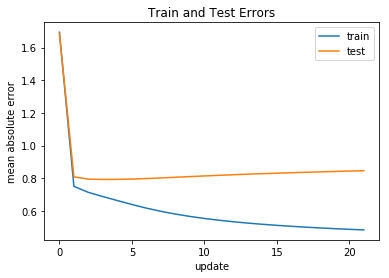

In [131]:
from numpy.linalg import norm
import math

n = len(users)
m = len(movies)
K = 20
lr = .01
show_every = 5
error_threshold = .1
split = .8
max_time = 120

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)

# I'm reinitializing the entries all over the place just in case you wanna run the cells in some weird order.
# There shouldn't be a way to fuck it up but God knows computer people will Find a Way. 
entries = list(zip(*data.nonzero()))
n_train = int(len(entries)*split)
all_indices = np.arange(len(entries))
train_indices = np.random.choice(all_indices,n_train,replace=False)
train_entries = [entries[i] for i in train_indices]
test_indices = np.setdiff1d(all_indices,train_indices)
test_entries = [entries[i] for i in test_indices]

# beta is our regularization coefficient. Like a learning rate but for regularization. Cool guy. $
# Toy with it. The bigger it is the smaller gap there should be between learning and testing. 
# It's usually around .02 by default.
beta = .02
        
error_train = mean_absolute_error(data,p,q,train_entries)
error_test = mean_absolute_error(data,p,q,test_entries)
train_errors = [error_train]
test_errors = [error_test]
iter=0
start = time.time()


#################################################
################# TRAINING LOOP #################
#################################################

while error_test > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0: 
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        local_error = data[i,j] - sum([p[i,k]*q[j,k] for k in range(K)])
        for k in range(K):
            # now this is where beta comes into play. Why? Math. That's why. Trust the system. 
            p[i,k] += lr*(2*local_error*q[j,k]-beta*p[i,k])
            q[j,k] += lr*(2*local_error*p[i,k]-beta*q[j,k])
    error_train = mean_absolute_error(data,p,q,train_entries)
    error_test = mean_absolute_error(data,p,q,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
################################################
################### PLOTTING ###################
################################################
 
x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

So the results still aren't quite satisfactory (still 0.5 point off on average in test), but at least we've put boundaries on over-fitting. 

The next thing to do is introduce biases.

### Biases

There are two layers of biases to add to this problem: 
   - the user bias: each user has a different average rating, which is considered to be their bias. Some users are more or less 'generous' with their ratings. 
   - the movie bias: each movie has its own average rating. Movies are 'more or less good', and sometimes two movies with the same latent features could be of very different qualities. 

In [133]:
rating_sum = data.sum()
average_rating = rating_sum/len(entries)

print("Average rating:",average_rating)

normalized_data = data.copy()
for entry in entries: normalized_data[entry] -= average_rating
# /!\ not the same as data -= average_rating
#     -> this will also apply it to all the empty cells of the matrix for whatever reason
    
print("Data normalized by average rating in normalized_data")

Average rating: 3.52986
Data normalized by average rating in normalized_data



Mean absolute error at iteration 0: (time = 0.0002970695495605469 )
	Train: 6.038726102358073 	Test: 6.011126090753465

Mean absolute error at iteration 5: (time = 33.2334361076355 )
	Train: 0.710953789926702 	Test: 0.7606693034017062

Mean absolute error at iteration 10: (time = 67.94253611564636 )
	Train: 0.6849207010016112 	Test: 0.741077208822015

Mean absolute error at iteration 15: (time = 99.23037362098694 )
	Train: 0.6648431672687555 	Test: 0.7298086314626497


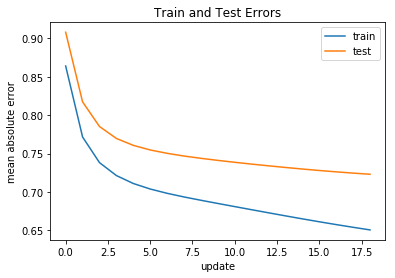

In [188]:
from numpy.linalg import norm
import math

n = len(users)
m = len(movies)
# parameters changed this time around with a grid search
# K < 3 seems very low. Honestly K = 3 seems very low. But it decreases our testing error so whatev.
K = 20
lr = .01
show_every = 5
error_threshold = .1
split = .9
max_time = 120

def updated_mean_absolute_error(r,p,q,u,m,local_entries):
    error = 0
    for (i,j) in local_entries:
        current_error = r[i,j] - (u[i]+m[j])
        for k in range(K): current_error -= p[i,k]*q[j,k]
        error += abs(current_error)
    return error/len(local_entries)

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)
user_bias = np.random.rand(n)
movie_bias = np.random.rand(m)

# entries = cells that contain a value in our data matrix
entries = list(zip(*data.nonzero()))
n_train = int(len(entries)*split)
all_indices = np.arange(len(entries))
train_indices = np.random.choice(all_indices,n_train,replace=False)
train_entries = [entries[i] for i in train_indices]
test_indices = np.setdiff1d(all_indices,train_indices)
test_entries = [entries[i] for i in test_indices]

beta = .1
        
error_train = updated_mean_absolute_error(normalized_data,p,q,user_bias,movie_bias,train_entries)
error_test = updated_mean_absolute_error(normalized_data,p,q,user_bias,movie_bias,test_entries)
train_errors = [error_train]
test_errors = [error_test]
iter=0
start = time.time()


#################################################
################# TRAINING LOOP #################
#################################################

while error_test > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0: 
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        actual_value = normalized_data[i,j]
        biases = user_bias[i] + movie_bias[j]
        deviance = sum([p[i,k]*q[j,k] for k in range(K)])
        local_error = actual_value - (biases+deviance)
        for k in range(K):
            # updating equations = derivatives of the error per parameter
            p[i,k] += lr*(local_error*q[j,k]-beta*p[i,k])
            q[j,k] += lr*(local_error*p[i,k]-beta*q[j,k])
        user_bias[i] += lr*(local_error-beta*user_bias[i])
        movie_bias[j] += lr*(local_error-beta*movie_bias[j])
        
    error_train = updated_mean_absolute_error(normalized_data,p,q,user_bias,movie_bias,train_entries)
    error_test = updated_mean_absolute_error(normalized_data,p,q,user_bias,movie_bias,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
################################################
################### PLOTTING ###################
################################################

x = range(len(train_errors)-1)
plt.plot(x,train_errors[1:],label='train')
plt.plot(x,test_errors[1:],label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

## Statistics on Error

At this point, there isn't much more we can do to improve our scores. It's all resting on hyper-parameter tuning, and the quality of the data. 

So let's look at the statistics on our error. It will give us a better idea of how efficient our model really is. 

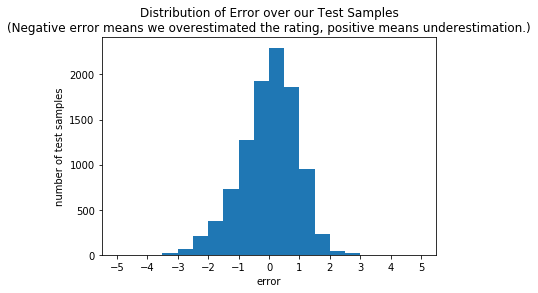

In [189]:
errors = list()
for user,movie in test_entries: 
    real_value = data[user,movie]
    prediction = sum([p[user,k]*q[movie,k] for k in range(K)])
    prediction += user_bias[user] + movie_bias[movie]
    prediction += average_rating
    errors.append(real_value - prediction)
    
hist = plt.hist(np.array(errors),bins=np.arange(-5,5.5,.5))
plt.title('Distribution of Error over our Test Samples\n(Negative error means we overestimated the rating, positive means underestimation.)')
plt.xlabel('error')
plt.ylabel('number of test samples')
plt.xticks(np.arange(-5,6,1))
plt.show()

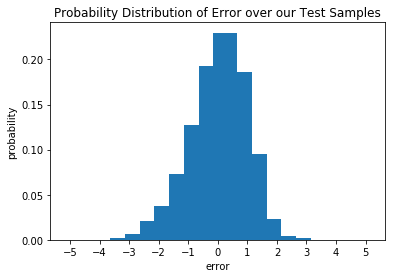

There is a 60.9 % chance of getting an absolute error <= 0.5
There is a 83.1 % chance of getting an absolute error <= 1
There is a 92.8 % chance of getting an absolute error <= 1.5
There is a 96.9 % chance of getting an absolute error <= 2


In [190]:
distribution = hist[0]
distribution /= sum(distribution)

plt.bar(np.arange(-4.75,5,.5),distribution)
plt.title('Probability Distribution of Error over our Test Samples')
plt.xlabel('error')
plt.ylabel('probability')
plt.xticks(np.arange(-5,6,1))
plt.show()

rating_to_id = dict(zip(hist[1],range(len(hist[1]))))
id_to_rating = dict(zip(range(len(hist[1])),hist[1]))

# returns probability that our error is between -abs_rating and abs_rating
def abs_proba(abs_rating):
    interval = np.arange(-abs_rating,abs_rating+.1,.5)
    return sum([distribution[rating_to_id[rating]] for rating in interval])

for abs_error in [.5,1,1.5,2]:
    proba = np.round(abs_proba(abs_error)*100,1)
    print('There is a',proba,'% chance of getting an absolute error <=',abs_error)

## Adding Basic Deep Learning to the Equation...

... because otherwise who's even having any fun? 

Our model isn't that bad as is. 

With K = 3, lr = .01, and split = .9, 4 out of 5 times, our predictions are less than 1 point away. A little under 2 out of 3 times, they're less than half a point away. 

But there are still ways to improve on this. We have obtained -- through matrix factorization -- latent representations of both our users and our movies. It might be interesting to plug in a neural net, and feed it the user + movie representations as inputs, and the ratings as targets. We have also learnt the user and movie biases, so it's now easy to substract them from our ratings to normalize them. 

### Pre-Processing

The first step is to get an input / target format for the data. 

In [191]:
def extract_x_y(local_entries):
    x,y = list(),list()
    for user,movie in local_entries:
        x.append(np.concatenate((p[user],q[movie])))
        biases = user_bias[user] + movie_bias[movie] + average_rating
        y.append(data[user,movie] - biases)
    return np.array(x),np.array(y)
        
x_tr,y_tr = extract_x_y(train_entries)
x_te,y_te = extract_x_y(test_entries)
print(len(x_tr),'training samples ready')
print(len(x_te),'testing samples ready')

90000 training samples ready
10000 testing samples ready


### Training and Testing

What we're doing here is regression (obviously), so we'll use the sklearn implementation of MLPs for regression. We're keeping it pretty simple, only changing the activation function to tanh. 

In [198]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,),activation='tanh',alpha=.1)
start = time.time()
mlp.fit(x_tr,y_tr)
print('Multi Layer Perceptron ready in',time.time()-start,'seconds')

start = time.time()
predictions_train = mlp.predict(x_tr)
predictions_test = mlp.predict(x_te)
print('Predictions made in',time.time()-start,'seconds')

def mlp_mean_absolute_error(predictions,labels):
    error = 0
    for i in range(len(predictions)):
        error += abs(labels[i]-predictions[i])
    return error/len(predictions)

print('Training error:',mlp_mean_absolute_error(predictions_train,y_tr))
print('Testing error:',mlp_mean_absolute_error(predictions_test,y_te))

Multi Layer Perceptron ready in 97.49032974243164 seconds
Predictions made in 0.36743998527526855 seconds
Training error: 0.5767324760211318
Testing error: 0.7544240941519152
